<img src="static/images/datachain-logo.png" alt="Dataset" style="width: 200px;"/>

# 💪 ML Training using Datachain and PyToch: Image Classification

In this tutorial, you'll learn how to train and evaluate an image classification model using **[Datachain](https://github.com/iterative/datachain)** and PyTorch. You'll load a dataset, add target labels, prepare data loaders, train the model, and evaluate its performance.

## 📋  Agenda

1. Load Dataset
2. Add Target Labels
3. Prepare Training Data Loader
4. Train the Model
5. Evaluate the Model
   

## 🛠 Prerequisites

Before you begin, ensure you have

- **[Datachain](https://github.com/iterative/datachain)** is installed in your environment.
- The necessary dependencies installed, including PyTorch and the required libraries (see `requirements.txt`).

So, fasten your seatbelts, and let's dive into image classification like never before! 🚀📷

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

from datachain import C, DataChain
from torch import optim
from torch.utils.data import DataLoader

from src.train import (
    CNN,
    build_evaluation_report,
    evaluate_model,
    train_model,
    transform,
)

# 🧩 Split train/test/val

**Note**: skip this stage if you already split datasets in `2-working-with-image-catalog.ipynb`

In this example, we define a `train_test_split` function to randomly split the dataset into the train, test, and validation sets. 

The workflow:
- Create a function that generates a random label (`"train"`, `"test"`, or `"val"`)
- Use the `map()` method to apply the function to each row
- Use the `filter()` and `save()` methods to save split datasets

## Define `train_test_split` function

- The function randomly chooses one of the labels (`"train"`, `"test"`, or `"val"`) using `random.choices` with the specified weights (`0.7`, `0.2`, and `0.1`, respectively).

In [2]:
def train_test_split(name) -> str:
    import random
    labels = ["train", "test", "val"]
    return random.choices(labels, weights = [0.7, 0.2, 0.1])[0]

## Add a signal (`split`)

- This code loads the `fashion-product-images` dataset.
- It then applies the batched UDF `train_test_split_batch` to the dataset, adding a new column `"split"` with the randomly assigned labels.
- Finally, it converts the dataset to a Pandas DataFrame and displays the first few rows using `head()`.

In [3]:
# Add signal

ds = (
    DataChain.from_dataset("fashion-product-images")
    .filter((C("masterCategory") == "Apparel") & (C("subCategory") == "Topwear"))
    .map(split=train_test_split, params=["file.name"], output=str)
    .save()
)

ds.to_pandas().head(3)

Processed: 0 rows [00:00, ? rows/s]

Processed: 10001 rows [00:00, 64724.70 rows/s]

Processed: 15401 rows [00:00, 56293.27 rows/s]

file                                                   \
                source                         parent       name   size   
0  gs://datachain-demo  fashion-product-images/images  10003.jpg  11564   
1  gs://datachain-demo  fashion-product-images/images  10005.jpg  16677   
2  gs://datachain-demo  fashion-product-images/images  10006.jpg   2146   

                                                 \
            version              etag is_latest   
0  1719489683599343  CO/fpJ7e+4YDEAE=         1   
1  1719489744441124  CKSeprve+4YDEAE=         1   
2  1719489713329967  CK+uu6ze+4YDEAE=         1   

                                                   ... mastercategory  \
                     last_modified location vtype  ...                  
0 2024-06-27 12:01:23.651000+00:00     None        ...        Apparel   
1 2024-06-27 12:02:24.500000+00:00     None        ...        Apparel   
2 2024-06-27 12:01:53.379000+00:00     None        ...        Apparel   

  subcategory articletype basecolour season    year   usage  \
                                                              
0     Topwear     Tshirts      White   Fall  2011.0  Sports   
1     Topwear     Tshirts       Blue   Fall  2011.0  Sports   
2     Topwear     Tshirts      Black   Fall  2011.0  Sports   

                       productdisplayname   filename  split  
                                                             
0  Nike Women As Nike Eleme White T-Shirt  10003.jpg   test  
1    Nike Men As Ss Trainin Blue T-Shirts  10005.jpg  train  
2           Nike Men AS T90 Black Tshirts  10006.jpg   test  

[3 rows x 21 columns]

By running this code, you'll get a Pandas DataFrame with a new column `split` containing the labels `"train", "test", or "val"` randomly assigned to each row based on the specified weights.

In [4]:
ds.to_pandas()["split"].value_counts()

split
train    10834
test      3098
val       1469
Name: count, dtype: int64

## Save `train`, `test` and `val` datasets

In [5]:
# Save train, test and val datasets

ds_train = (ds.filter(C("split") == "train").save("fashion-train"))
ds_test = (ds.filter(C("split") == "test").save("fashion-test"))
ds_val = (ds.filter(C("split") == "val").save("fashion-val"))


After running this code, you'll have three separate datasets:

1. `fashion-train`: Contains the rows from the original dataset where `split` is `'train'`.
2. `fashion-test`: Contains the rows from the original dataset where `split` is `'test'`.
3. `fashion-val`: Contains the rows from the original dataset where `split` is `'val'`.

You can now use these datasets for training, testing, and validating your machine learning models, respectively.

# 🎯 Define Target

This section focuses on how you can utilize DataChain to dynamically add target labels to an image dataset. This is particularly useful when dealing with multi-class categorization tasks, such as classifying fashion items into various style categories.

In the given example, we define a list of possible label_names that represent different fashion styles. These labels will serve as our target classes. Using DataChain's udf (user-defined function) feature, we create a function add_target_label that assigns each item in the dataset a target label based on its usage attribute.


## Define Classes 

In [8]:
# Define classes
CLASSES = [
        "Casual",
        "Ethnic",
        "Sports",
        "Formal",
        "Party",
        "Smart Casual",
        "Travel",
        "nan",
    ]
NUM_CLASSES = len(CLASSES)

print(CLASSES, NUM_CLASSES)

['Casual', 'Ethnic', 'Sports', 'Formal', 'Party', 'Smart Casual', 'Travel', 'nan'] 8


## Create a Target column

The `add_target_label` UDF processes batches of labels, ensuring efficient handling of large datasets. It assigns a label from `CLASSES` or defaults to "nan" if the existing label doesn't match any predefined category. 


In [10]:
from datachain.lib.pytorch import label_to_int

def add_target_label(usage) -> str:
    return usage if usage in CLASSES else "nan"

ds = (
    DataChain(name="fashion-train")
    .limit(100) # Take a sample for the DEMO purposes
    .map(target=add_target_label, params=["usage"], output=str)
    .map(label=lambda target: label_to_int(target, CLASSES), output=int)
    .shuffle()
)

- `add_target_label` is a user-defined function (UDF) that adds target labels to the dataset
- The UDF is applied using `add_signals()`, and the dataset is shuffled

In [11]:
print(ds.to_pandas().target.value_counts())

Processed: 100 rows [00:00, 9982.16 rows/s]
Processed: 100 rows [00:00, 28587.13 rows/s]

target
Casual    81
Sports    16
Formal     3
Name: count, dtype: int64


# 🧠 Train Model

Now that you have your dataset loaded and targets defined, it's time to embark on the exciting journey of training your image classification model! DataChain seamlessly integrates with PyTorch, providing you with a powerful and intuitive workflow to train your model effectively. 🚀

## Prepare the training data loader

To feed your model with the right data during training, you need to prepare a PyTorch DataLoader. DataChain makes this process a breeze! 💨

The code snippet below uses PyTorch's `DataLoader`, which facilitates the efficient loading of data in batches, handling parallel processing with ease.  The `ds.to_pytorch()` function converts the DataChain dataset into a format compatible with PyTorch, leveraging custom readers for images and labels:

<!-- - `ImageReader()`: Handles the reading and preprocessing of image data.
- `LabelReader(fr_class="target", classes=label_names)`: Fetches labels corresponding to each image, necessary for supervised learning. -->

In [12]:
# Pytroch DataLoader

train_loader = DataLoader(
    ds.select("file", "label").to_pytorch(transform=transform),
    batch_size=2,
    num_workers=1,
)

Processed: 100 rows [00:00, 29587.36 rows/s]
Processed: 100 rows [00:00, 30675.81 rows/s]


Processed: 0 rows [00:00, ? rows/s]

Processed: 500 rows [00:00, 36493.79 rows/s]

Notes: 
- The dataset `ds` includes a 'target' column, which contains the labels for training derived from the previous steps in this tutorial.
- `to_pytorch()` converts the dataset to a PyTorch dataset
- `transform` is a custom transformation function (imported from `src.train`)

## Train the model

With the dataloader ready, the next step involves initiating the model training. The `train_model` function is a wrapper on typical PyTorch training scripts that takes the prepared `train_loader`. 

By leveraging the power of PyTorch and DataChain, you can easily train your image classification model on your dataset.

`train_loader` trains a convolutional neural network on a given dataset.

Args:
- train_loader (DataLoader): DataLoader for the training data.
- num_classes (int): Number of classes in the dataset.
- num_epochs (int, optional): Number of epochs to train the model. Defaults to 20.
- lr (float, optional): Learning rate for the optimizer. Defaults to 0.001.

Returns:
- tuple: A tuple containing the trained model and the optimizer used for training.



<details>
<summary>Code for the imported `train_model`</summary>

```python

# Data Transformations
transform = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize((64, 64)),
    v2.RGB()
])


# Define torch model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Train  #####
def train_model(train_loader, num_classes, num_epochs=20, lr=0.001):

    model = CNN(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch_loss = []

    for epoch in range(num_epochs):
        for i, data in tqdm(enumerate(train_loader)):
            inputs, labels = data
            # inputs = data[0]
            # labels = data[1]
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_loss.append(loss.item())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        epoch_mean_loss = np.mean(epoch_loss)
        print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, epoch_mean_loss))
        epoch_loss = []

    print("Finished Training")
    return model, optimizer
```

</details>




In [13]:
model, optimizer = train_model(train_loader, NUM_CLASSES, num_epochs=3,  lr=0.001)

50it [00:41,  1.21it/s]

[1,    50] loss: 0.797



50it [00:41,  1.20it/s]

[2,    50] loss: 0.688



50it [00:40,  1.24it/s]

[3,    50] loss: 0.604
Finished Training


14it [00:10,  1.58it/s]

15it [00:11,  1.60it/s]

16it [00:12,  1.55it/s]

17it [00:12,  1.42it/s]

18it [00:13,  1.38it/s]

19it [00:14,  1.46it/s]

20it [00:14,  1.50it/s]

21it [00:15,  1.56it/s]

22it [00:16,  1.52it/s]

23it [00:16,  1.56it/s]

24it [00:17,  1.55it/s]

25it [00:18,  1.48it/s]

26it [00:18,  1.53it/s]

27it [00:19,  1.56it/s]

28it [00:20,  1.59it/s]

29it [00:20,  1.48it/s]

30it [00:21,  1.49it/s]

31it [00:22,  1.50it/s]

32it [00:22,  1.51it/s]

33it [00:23,  1.43it/s]

34it [00:24,  1.38it/s]

35it [00:25,  1.38it/s]

36it [00:25,  1.37it/s]

37it [00:26,  1.44it/s]

38it [00:27,  1.50it/s]

39it [00:27,  1.55it/s]

40it [00:28,  1.55it/s]

41it [00:28,  1.60it/s]

42it [00:29,  1.62it/s]

43it [00:30,  1.62it/s]

44it [00:30,  1.59it/s]

45it [00:31,  1.59it/s]

46it [00:31,  1.63it/s]

47it [00:32,  1.64it/s]

48it [00:33,  1.61it/s]

49it [00:33,  1.57it/s]

50it [00:34,  1.58it/s]

51it [00:35,  1.56it/s]

52it [00:35,  1.60it/s]

53it [00:36,  1.62it/s]

54it [00:36,  1.62it/s]

55it [00:37,  1.65it/s]

56it [00:38,  1.57it/s]

57it [00:38,  1.58it/s]

58it [00:39,  1.60it/s]

59it [00:40,  1.61it/s]

60it [00:40,  1.62it/s]

61it [00:41,  1.64it/s]

62it [00:41,  1.63it/s]

63it [00:42,  1.62it/s]

64it [00:43,  1.59it/s]

65it [00:43,  1.57it/s]

66it [00:44,  1.56it/s]

67it [00:45,  1.55it/s]

68it [00:45,  1.56it/s]

69it [00:46,  1.55it/s]

70it [00:47,  1.55it/s]

71it [00:47,  1.54it/s]

72it [00:48,  1.54it/s]

73it [00:49,  1.57it/s]

74it [00:49,  1.55it/s]

75it [00:50,  1.56it/s]

76it [00:51,  1.50it/s]

77it [00:51,  1.50it/s]

78it [00:52,  1.55it/s]

79it [00:53,  1.50it/s]

80it [00:53,  1.53it/s]

81it [00:54,  1.56it/s]

82it [00:54,  1.58it/s]

83it [00:55,  1.53it/s]

84it [00:56,  1.49it/s]

85it [00:56,  1.51it/s]

86it [00:57,  1.51it/s]

87it [00:58,  1.50it/s]

88it [00:58,  1.55it/s]

89it [00:59,  1.56it/s]

90it [01:00,  1.57it/s]

91it [01:00,  1.57it/s]

92it [01:01,  1.60it/s]

93it [01:01,  1.62it/s]

94it [01:02,  1.62it/s]

95it [01:03,  1.61it/s]

96it [01:03,  1.64it/s]

97it [01:04,  1.60it/s]

98it [01:05,  1.62it/s]

99it [01:05,  1.61it/s]

100it [01:06,  1.65it/s]

101it [01:07,  1.54it/s]

102it [01:07,  1.56it/s]

103it [01:08,  1.57it/s]

104it [01:08,  1.55it/s]

105it [01:09,  1.56it/s]

106it [01:10,  1.56it/s]

107it [01:10,  1.57it/s]

108it [01:11,  1.57it/s]

109it [01:12,  1.50it/s]

110it [01:12,  1.50it/s]

111it [01:13,  1.55it/s]

112it [01:14,  1.59it/s]

113it [01:14,  1.62it/s]

114it [01:15,  1.63it/s]

115it [01:15,  1.57it/s]

116it [01:16,  1.61it/s]

117it [01:17,  1.59it/s]

118it [01:17,  1.58it/s]

119it [01:18,  1.58it/s]

120it [01:19,  1.46it/s]

121it [01:19,  1.51it/s]

122it [01:20,  1.38it/s]

123it [01:21,  1.43it/s]

124it [01:21,  1.49it/s]

125it [01:22,  1.54it/s]

126it [01:23,  1.53it/s]

127it [01:23,  1.57it/s]

128it [01:24,  1.57it/s]

129it [01:25,  1.61it/s]

130it [01:25,  1.65it/s]

131it [01:26,  1.66it/s]

132it [01:26,  1.62it/s]

133it [01:27,  1.65it/s]

134it [01:28,  1.65it/s]

135it [01:28,  1.61it/s]

136it [01:29,  1.63it/s]

137it [01:30,  1.58it/s]

138it [01:30,  1.58it/s]

139it [01:31,  1.56it/s]

140it [01:31,  1.61it/s]

141it [01:32,  1.61it/s]

142it [01:33,  1.58it/s]

143it [01:33,  1.61it/s]

144it [01:34,  1.58it/s]

145it [01:34,  1.62it/s]

146it [01:35,  1.65it/s]

147it [01:36,  1.65it/s]

148it [01:36,  1.67it/s]

149it [01:37,  1.67it/s]

150it [01:37,  1.67it/s]

151it [01:38,  1.67it/s]

152it [01:39,  1.63it/s]

153it [01:39,  1.62it/s]

154it [01:40,  1.56it/s]

155it [01:41,  1.60it/s]

156it [01:41,  1.62it/s]

157it [01:42,  1.58it/s]

158it [01:42,  1.60it/s]

159it [01:43,  1.58it/s]

160it [01:44,  1.62it/s]

161it [01:44,  1.64it/s]

162it [01:45,  1.64it/s]

163it [01:46,  1.62it/s]

164it [01:46,  1.63it/s]

165it [01:47,  1.63it/s]

166it [01:47,  1.56it/s]

167it [01:48,  1.54it/s]

168it [01:49,  1.55it/s]

169it [01:49,  1.56it/s]

170it [01:50,  1.55it/s]

171it [01:51,  1.55it/s]

172it [01:51,  1.55it/s]

173it [01:52,  1.59it/s]

174it [01:53,  1.56it/s]

175it [01:53,  1.55it/s]

176it [01:54,  1.56it/s]

177it [01:55,  1.55it/s]

178it [01:55,  1.59it/s]

179it [01:56,  1.62it/s]

180it [01:56,  1.61it/s]

181it [01:57,  1.50it/s]

182it [01:58,  1.56it/s]

183it [01:58,  1.56it/s]

184it [01:59,  1.53it/s]

185it [02:00,  1.52it/s]

186it [02:00,  1.58it/s]

187it [02:01,  1.61it/s]

188it [02:01,  1.62it/s]

189it [02:02,  1.60it/s]

190it [02:03,  1.52it/s]

191it [02:03,  1.55it/s]

192it [02:04,  1.55it/s]

193it [02:05,  1.57it/s]

194it [02:05,  1.56it/s]

195it [02:06,  1.58it/s]

196it [02:07,  1.53it/s]

197it [02:07,  1.52it/s]

198it [02:08,  1.47it/s]

199it [02:09,  1.54it/s]

200it [02:09,  1.58it/s]

201it [02:10,  1.56it/s]

202it [02:11,  1.56it/s]

203it [02:11,  1.56it/s]

204it [02:12,  1.52it/s]

205it [02:13,  1.56it/s]

206it [02:13,  1.58it/s]

207it [02:14,  1.52it/s]

208it [02:14,  1.58it/s]

209it [02:15,  1.61it/s]

210it [02:16,  1.60it/s]

211it [02:16,  1.56it/s]

212it [02:17,  1.57it/s]

213it [02:18,  1.58it/s]

214it [02:18,  1.63it/s]

215it [02:19,  1.62it/s]

216it [02:20,  1.54it/s]

217it [02:20,  1.41it/s]

218it [02:21,  1.37it/s]

219it [02:22,  1.43it/s]

220it [02:22,  1.52it/s]

221it [02:23,  1.57it/s]

222it [02:24,  1.61it/s]

223it [02:24,  1.53it/s]

224it [02:25,  1.56it/s]

225it [02:25,  1.59it/s]

226it [02:26,  1.61it/s]

227it [02:27,  1.65it/s]

228it [02:27,  1.61it/s]

229it [02:28,  1.57it/s]

230it [02:29,  1.58it/s]

231it [02:29,  1.61it/s]

232it [02:30,  1.61it/s]

233it [02:31,  1.48it/s]

234it [02:31,  1.51it/s]

235it [02:32,  1.52it/s]

236it [02:33,  1.53it/s]

237it [02:33,  1.54it/s]

238it [02:34,  1.59it/s]

239it [02:34,  1.54it/s]

240it [02:35,  1.58it/s]

241it [02:36,  1.60it/s]

242it [02:36,  1.58it/s]

243it [02:37,  1.48it/s]

244it [02:38,  1.50it/s]

245it [02:38,  1.53it/s]

246it [02:39,  1.57it/s]

247it [02:40,  1.58it/s]

248it [02:40,  1.59it/s]

249it [02:41,  1.57it/s]

250it [02:41,  1.60it/s]

250it [02:46,  1.50it/s]

[1,   250] loss: 0.693


0it [00:00, ?it/s]

1it [00:02,  2.82s/it]

2it [00:03,  1.54s/it]

3it [00:04,  1.44s/it]

4it [00:05,  1.12s/it]

5it [00:06,  1.05it/s]

6it [00:06,  1.21it/s]

7it [00:07,  1.33it/s]

8it [00:07,  1.45it/s]

9it [00:08,  1.54it/s]

10it [00:08,  1.59it/s]

11it [00:09,  1.62it/s]

12it [00:10,  1.65it/s]

13it [00:10,  1.66it/s]

14it [00:11,  1.61it/s]

15it [00:11,  1.64it/s]

16it [00:12,  1.61it/s]

17it [00:13,  1.61it/s]

18it [00:13,  1.64it/s]

19it [00:14,  1.67it/s]

20it [00:14,  1.66it/s]

21it [00:15,  1.66it/s]

22it [00:16,  1.66it/s]

23it [00:16,  1.68it/s]

24it [00:17,  1.65it/s]

25it [00:18,  1.58it/s]

26it [00:18,  1.61it/s]

27it [00:19,  1.66it/s]

28it [00:19,  1.64it/s]

29it [00:20,  1.52it/s]

30it [00:21,  1.50it/s]

31it [00:21,  1.54it/s]

32it [00:22,  1.59it/s]

33it [00:23,  1.55it/s]

34it [00:23,  1.61it/s]

35it [00:24,  1.63it/s]

36it [00:25,  1.57it/s]

37it [00:25,  1.63it/s]

38it [00:26,  1.64it/s]

39it [00:26,  1.66it/s]

40it [00:27,  1.64it/s]

41it [00:28,  1.67it/s]

42it [00:28,  1.67it/s]

43it [00:29,  1.69it/s]

44it [00:29,  1.69it/s]

45it [00:30,  1.69it/s]

46it [00:30,  1.70it/s]

47it [00:31,  1.69it/s]

48it [00:32,  1.59it/s]

49it [00:32,  1.61it/s]

50it [00:33,  1.65it/s]

51it [00:34,  1.63it/s]

52it [00:34,  1.64it/s]

53it [00:35,  1.68it/s]

54it [00:35,  1.70it/s]

55it [00:36,  1.71it/s]

56it [00:37,  1.68it/s]

57it [00:37,  1.69it/s]

58it [00:38,  1.66it/s]

59it [00:38,  1.67it/s]

60it [00:39,  1.67it/s]

61it [00:40,  1.66it/s]

62it [00:40,  1.67it/s]

63it [00:41,  1.67it/s]

64it [00:41,  1.67it/s]

65it [00:42,  1.68it/s]

66it [00:43,  1.64it/s]

67it [00:43,  1.60it/s]

68it [00:44,  1.62it/s]

69it [00:44,  1.62it/s]

70it [00:45,  1.62it/s]

71it [00:46,  1.61it/s]

72it [00:46,  1.63it/s]

73it [00:47,  1.68it/s]

74it [00:47,  1.66it/s]

75it [00:48,  1.67it/s]

76it [00:49,  1.68it/s]

77it [00:49,  1.64it/s]

78it [00:50,  1.63it/s]

79it [00:51,  1.57it/s]

80it [00:51,  1.59it/s]

81it [00:52,  1.63it/s]

82it [00:52,  1.67it/s]

83it [00:53,  1.64it/s]

84it [00:54,  1.61it/s]

85it [00:54,  1.57it/s]

86it [00:55,  1.60it/s]

87it [00:55,  1.59it/s]

88it [00:56,  1.63it/s]

89it [00:57,  1.55it/s]

90it [00:57,  1.59it/s]

91it [00:58,  1.60it/s]

92it [00:59,  1.62it/s]

93it [00:59,  1.63it/s]

94it [01:00,  1.65it/s]

95it [01:00,  1.67it/s]

96it [01:01,  1.67it/s]

97it [01:02,  1.59it/s]

98it [01:02,  1.61it/s]

99it [01:03,  1.60it/s]

100it [01:04,  1.62it/s]

101it [01:04,  1.58it/s]

102it [01:05,  1.59it/s]

103it [01:05,  1.61it/s]

104it [01:06,  1.58it/s]

105it [01:07,  1.58it/s]

106it [01:07,  1.59it/s]

107it [01:08,  1.57it/s]

108it [01:09,  1.56it/s]

109it [01:09,  1.55it/s]

110it [01:10,  1.59it/s]

111it [01:10,  1.62it/s]

112it [01:11,  1.63it/s]

113it [01:12,  1.64it/s]

114it [01:12,  1.66it/s]

115it [01:13,  1.61it/s]

116it [01:13,  1.66it/s]

117it [01:14,  1.66it/s]

118it [01:15,  1.68it/s]

119it [01:15,  1.67it/s]

120it [01:16,  1.60it/s]

121it [01:17,  1.63it/s]

122it [01:17,  1.57it/s]

123it [01:18,  1.57it/s]

124it [01:18,  1.62it/s]

125it [01:19,  1.63it/s]

126it [01:20,  1.63it/s]

127it [01:20,  1.62it/s]

128it [01:21,  1.63it/s]

129it [01:21,  1.64it/s]

130it [01:22,  1.65it/s]

131it [01:23,  1.63it/s]

132it [01:23,  1.61it/s]

133it [01:24,  1.63it/s]

134it [01:25,  1.63it/s]

135it [01:25,  1.64it/s]

136it [01:26,  1.66it/s]

137it [01:26,  1.58it/s]

138it [01:27,  1.61it/s]

139it [01:28,  1.56it/s]

140it [01:28,  1.61it/s]

141it [01:29,  1.61it/s]

142it [01:30,  1.61it/s]

143it [01:30,  1.64it/s]

144it [01:31,  1.58it/s]

145it [01:31,  1.61it/s]

146it [01:32,  1.61it/s]

147it [01:33,  1.62it/s]

148it [01:33,  1.65it/s]

149it [01:34,  1.66it/s]

150it [01:34,  1.66it/s]

151it [01:35,  1.68it/s]

152it [01:36,  1.64it/s]

153it [01:36,  1.66it/s]

154it [01:37,  1.65it/s]

155it [01:37,  1.66it/s]

156it [01:38,  1.67it/s]

157it [01:39,  1.63it/s]

158it [01:39,  1.68it/s]

159it [01:40,  1.66it/s]

160it [01:40,  1.67it/s]

161it [01:41,  1.70it/s]

162it [01:42,  1.72it/s]

163it [01:42,  1.68it/s]

164it [01:43,  1.69it/s]

165it [01:43,  1.66it/s]

166it [01:44,  1.61it/s]

167it [01:45,  1.60it/s]

168it [01:45,  1.60it/s]

169it [01:46,  1.64it/s]

170it [01:47,  1.60it/s]

171it [01:47,  1.63it/s]

172it [01:48,  1.60it/s]

173it [01:48,  1.60it/s]

174it [01:49,  1.53it/s]

175it [01:50,  1.54it/s]

176it [01:50,  1.57it/s]

177it [01:51,  1.57it/s]

178it [01:52,  1.60it/s]

179it [01:52,  1.61it/s]

180it [01:53,  1.64it/s]

181it [01:53,  1.62it/s]

182it [01:54,  1.62it/s]

183it [01:55,  1.64it/s]

184it [01:55,  1.61it/s]

185it [01:56,  1.57it/s]

186it [01:57,  1.61it/s]

187it [01:57,  1.61it/s]

188it [01:58,  1.64it/s]

189it [01:58,  1.61it/s]

190it [01:59,  1.55it/s]

191it [02:00,  1.60it/s]

192it [02:00,  1.60it/s]

193it [02:01,  1.63it/s]

194it [02:02,  1.60it/s]

195it [02:02,  1.61it/s]

196it [02:03,  1.56it/s]

197it [02:03,  1.56it/s]

198it [02:04,  1.49it/s]

199it [02:05,  1.55it/s]

200it [02:05,  1.59it/s]

201it [02:06,  1.58it/s]

202it [02:07,  1.59it/s]

203it [02:07,  1.60it/s]

204it [02:08,  1.50it/s]

205it [02:09,  1.56it/s]

206it [02:09,  1.61it/s]

207it [02:10,  1.57it/s]

208it [02:10,  1.61it/s]

209it [02:11,  1.63it/s]

210it [02:12,  1.62it/s]

211it [02:12,  1.57it/s]

212it [02:13,  1.60it/s]

213it [02:14,  1.62it/s]

214it [02:14,  1.66it/s]

215it [02:15,  1.66it/s]

216it [02:15,  1.66it/s]

217it [02:16,  1.57it/s]

218it [02:17,  1.58it/s]

219it [02:17,  1.60it/s]

220it [02:18,  1.64it/s]

221it [02:18,  1.66it/s]

222it [02:19,  1.63it/s]

223it [02:20,  1.61it/s]

224it [02:20,  1.59it/s]

225it [02:21,  1.62it/s]

226it [02:22,  1.63it/s]

227it [02:22,  1.65it/s]

228it [02:23,  1.63it/s]

229it [02:23,  1.60it/s]

230it [02:24,  1.62it/s]

231it [02:25,  1.64it/s]

232it [02:25,  1.62it/s]

233it [02:26,  1.61it/s]

234it [02:27,  1.61it/s]

235it [02:27,  1.61it/s]

236it [02:28,  1.64it/s]

237it [02:28,  1.56it/s]

238it [02:29,  1.59it/s]

239it [02:30,  1.58it/s]

240it [02:30,  1.60it/s]

241it [02:31,  1.64it/s]

242it [02:32,  1.59it/s]

243it [02:32,  1.61it/s]

244it [02:33,  1.58it/s]

245it [02:33,  1.61it/s]

246it [02:34,  1.64it/s]

247it [02:35,  1.64it/s]

248it [02:35,  1.67it/s]

249it [02:36,  1.66it/s]

250it [02:36,  1.61it/s]

250it [02:41,  1.54it/s]

[2,   250] loss: 0.334


0it [00:00, ?it/s]

1it [00:02,  2.83s/it]

2it [00:03,  1.55s/it]

3it [00:04,  1.10s/it]

4it [00:04,  1.13it/s]

5it [00:05,  1.28it/s]

6it [00:05,  1.40it/s]

7it [00:06,  1.48it/s]

8it [00:06,  1.54it/s]

9it [00:07,  1.59it/s]

10it [00:08,  1.64it/s]

11it [00:08,  1.66it/s]

12it [00:09,  1.70it/s]

13it [00:09,  1.71it/s]

14it [00:10,  1.67it/s]

15it [00:11,  1.69it/s]

16it [00:11,  1.65it/s]

17it [00:12,  1.60it/s]

18it [00:12,  1.64it/s]

19it [00:13,  1.67it/s]

20it [00:14,  1.67it/s]

21it [00:14,  1.67it/s]

22it [00:15,  1.64it/s]

23it [00:15,  1.67it/s]

24it [00:16,  1.62it/s]

25it [00:17,  1.57it/s]

26it [00:17,  1.58it/s]

27it [00:18,  1.64it/s]

28it [00:19,  1.66it/s]

29it [00:19,  1.56it/s]

30it [00:20,  1.57it/s]

31it [00:20,  1.60it/s]

32it [00:21,  1.64it/s]

33it [00:22,  1.59it/s]

34it [00:22,  1.63it/s]

35it [00:23,  1.66it/s]

36it [00:24,  1.60it/s]

37it [00:24,  1.64it/s]

38it [00:25,  1.64it/s]

39it [00:25,  1.65it/s]

40it [00:26,  1.65it/s]

41it [00:27,  1.68it/s]

42it [00:27,  1.69it/s]

43it [00:28,  1.71it/s]

44it [00:28,  1.70it/s]

45it [00:29,  1.70it/s]

46it [00:29,  1.71it/s]

47it [00:30,  1.73it/s]

48it [00:31,  1.65it/s]

49it [00:31,  1.68it/s]

50it [00:32,  1.69it/s]

51it [00:32,  1.65it/s]

52it [00:33,  1.64it/s]

53it [00:34,  1.68it/s]

54it [00:34,  1.66it/s]

55it [00:35,  1.69it/s]

56it [00:35,  1.68it/s]

57it [00:36,  1.71it/s]

58it [00:37,  1.71it/s]

59it [00:37,  1.70it/s]

60it [00:38,  1.69it/s]

61it [00:38,  1.71it/s]

62it [00:39,  1.70it/s]

63it [00:39,  1.71it/s]

64it [00:40,  1.71it/s]

65it [00:41,  1.73it/s]

66it [00:41,  1.70it/s]

67it [00:42,  1.65it/s]

68it [00:42,  1.67it/s]

69it [00:43,  1.67it/s]

70it [00:44,  1.65it/s]

71it [00:44,  1.66it/s]

72it [00:45,  1.67it/s]

73it [00:45,  1.70it/s]

74it [00:46,  1.71it/s]

75it [00:47,  1.71it/s]

76it [00:47,  1.69it/s]

77it [00:48,  1.69it/s]

78it [00:48,  1.66it/s]

79it [00:49,  1.61it/s]

80it [00:50,  1.60it/s]

81it [00:50,  1.65it/s]

82it [00:51,  1.67it/s]

83it [00:52,  1.64it/s]

84it [00:52,  1.62it/s]

85it [00:53,  1.59it/s]

86it [00:53,  1.63it/s]

87it [00:54,  1.66it/s]

88it [00:55,  1.68it/s]

89it [00:55,  1.64it/s]

90it [00:56,  1.67it/s]

91it [00:56,  1.66it/s]

92it [00:57,  1.69it/s]

93it [00:58,  1.67it/s]

94it [00:58,  1.69it/s]

95it [00:59,  1.69it/s]

96it [00:59,  1.71it/s]

97it [01:00,  1.68it/s]

98it [01:00,  1.70it/s]

99it [01:01,  1.68it/s]

100it [01:02,  1.70it/s]

101it [01:02,  1.65it/s]

102it [01:03,  1.63it/s]

103it [01:04,  1.66it/s]

104it [01:04,  1.62it/s]

105it [01:05,  1.63it/s]

106it [01:05,  1.63it/s]

107it [01:06,  1.61it/s]

108it [01:07,  1.63it/s]

109it [01:07,  1.60it/s]

110it [01:08,  1.61it/s]

111it [01:08,  1.65it/s]

112it [01:09,  1.68it/s]

113it [01:10,  1.70it/s]

114it [01:10,  1.71it/s]

115it [01:11,  1.70it/s]

116it [01:11,  1.71it/s]

117it [01:12,  1.71it/s]

118it [01:13,  1.71it/s]

119it [01:13,  1.70it/s]

120it [01:14,  1.66it/s]

121it [01:14,  1.69it/s]

122it [01:15,  1.63it/s]

123it [01:16,  1.58it/s]

124it [01:16,  1.62it/s]

125it [01:17,  1.66it/s]

126it [01:17,  1.65it/s]

127it [01:18,  1.65it/s]

128it [01:19,  1.64it/s]

129it [01:19,  1.69it/s]

130it [01:20,  1.70it/s]

131it [01:20,  1.68it/s]

132it [01:21,  1.69it/s]

133it [01:22,  1.72it/s]

134it [01:22,  1.73it/s]

135it [01:23,  1.74it/s]

136it [01:23,  1.72it/s]

137it [01:24,  1.69it/s]

138it [01:24,  1.66it/s]

139it [01:25,  1.67it/s]

140it [01:26,  1.68it/s]

141it [01:26,  1.67it/s]

142it [01:27,  1.65it/s]

143it [01:27,  1.68it/s]

144it [01:28,  1.65it/s]

145it [01:29,  1.68it/s]

146it [01:29,  1.72it/s]

147it [01:30,  1.71it/s]

148it [01:30,  1.73it/s]

149it [01:31,  1.71it/s]

150it [01:32,  1.72it/s]

151it [01:32,  1.73it/s]

152it [01:33,  1.71it/s]

153it [01:33,  1.73it/s]

154it [01:34,  1.69it/s]

155it [01:34,  1.70it/s]

156it [01:35,  1.68it/s]

157it [01:36,  1.65it/s]

158it [01:36,  1.68it/s]

159it [01:37,  1.69it/s]

160it [01:37,  1.71it/s]

161it [01:38,  1.72it/s]

162it [01:39,  1.73it/s]

163it [01:39,  1.63it/s]

164it [01:40,  1.67it/s]

165it [01:40,  1.67it/s]

166it [01:41,  1.62it/s]

167it [01:42,  1.64it/s]

168it [01:42,  1.63it/s]

169it [01:43,  1.66it/s]

170it [01:44,  1.65it/s]

171it [01:44,  1.68it/s]

172it [01:45,  1.62it/s]

173it [01:45,  1.65it/s]

174it [01:46,  1.61it/s]

175it [01:47,  1.62it/s]

176it [01:47,  1.63it/s]

177it [01:48,  1.63it/s]

178it [01:48,  1.68it/s]

179it [01:49,  1.70it/s]

180it [01:50,  1.69it/s]

181it [01:50,  1.69it/s]

182it [01:51,  1.64it/s]

183it [01:51,  1.65it/s]

184it [01:52,  1.60it/s]

185it [01:53,  1.60it/s]

186it [01:53,  1.65it/s]

187it [01:54,  1.68it/s]

188it [01:54,  1.67it/s]

189it [01:55,  1.65it/s]

190it [01:56,  1.58it/s]

191it [01:56,  1.63it/s]

192it [01:57,  1.63it/s]

193it [01:58,  1.66it/s]

194it [01:58,  1.59it/s]

195it [01:59,  1.61it/s]

196it [01:59,  1.59it/s]

197it [02:00,  1.62it/s]

198it [02:01,  1.59it/s]

199it [02:01,  1.59it/s]

200it [02:02,  1.60it/s]

201it [02:03,  1.60it/s]

202it [02:03,  1.60it/s]

203it [02:04,  1.60it/s]

204it [02:04,  1.59it/s]

205it [02:05,  1.63it/s]

206it [02:06,  1.65it/s]

207it [02:07,  1.42it/s]

208it [02:07,  1.37it/s]

209it [02:08,  1.38it/s]

210it [02:09,  1.39it/s]

211it [02:10,  1.37it/s]

212it [02:10,  1.39it/s]

213it [02:11,  1.39it/s]

214it [02:12,  1.46it/s]

215it [02:12,  1.51it/s]

216it [02:13,  1.58it/s]

217it [02:13,  1.61it/s]

218it [02:14,  1.63it/s]

219it [02:15,  1.63it/s]

220it [02:15,  1.67it/s]

221it [02:16,  1.69it/s]

222it [02:16,  1.69it/s]

223it [02:17,  1.60it/s]

224it [02:18,  1.62it/s]

225it [02:18,  1.65it/s]

226it [02:19,  1.69it/s]

227it [02:19,  1.69it/s]

228it [02:20,  1.67it/s]

229it [02:20,  1.66it/s]

230it [02:21,  1.67it/s]

231it [02:22,  1.71it/s]

232it [02:22,  1.57it/s]

233it [02:23,  1.60it/s]

234it [02:24,  1.58it/s]

235it [02:24,  1.59it/s]

236it [02:25,  1.64it/s]

237it [02:25,  1.61it/s]

238it [02:26,  1.65it/s]

239it [02:27,  1.65it/s]

240it [02:27,  1.68it/s]

241it [02:28,  1.71it/s]

242it [02:29,  1.57it/s]

243it [02:29,  1.59it/s]

244it [02:30,  1.59it/s]

245it [02:30,  1.64it/s]

246it [02:31,  1.66it/s]

247it [02:32,  1.68it/s]

248it [02:32,  1.70it/s]

249it [02:33,  1.73it/s]

250it [02:33,  1.73it/s]

250it [02:38,  1.57it/s]

[3,   250] loss: 0.177
Finished Training


# 📊 Evaluate model 

Congratulations on successfully training your image classification model! 🎉  Now it's time to put your model to the test and evaluate its performance on unseen data. 

DataChain makes it easy to load your test dataset, create a test data loader, and evaluate your model's predictions against the true labels. 🎯

## Create the Test Data Loader

In [11]:
# Load Dataset

ds_test = (
  DataChain.from_dataset("fashion-test")
    .map(target=add_target_label, params=["usage"], output=str)
    .map(label=lambda target: label_to_int(target, CLASSES), output=int)
    .select("file", "label")
    .limit(500) # Take a sample for the DEMO purposes
)

# Creating the Test Data Loader

test_loader = DataLoader(
    ds_test.to_pytorch(transform=transform),
    batch_size=16,
    num_workers=2,
)

Processed: 0 rows [00:00, ? rows/s]

Processed: 3098 rows [00:00, 23626.32 rows/s]

Processed: 0 rows [00:00, ? rows/s]

Processed: 3098 rows [00:00, 48233.66 rows/s]

- The test dataset is loaded
- A test data loader is created
- `evaluate_model()` evaluates the model on the test data (imported from `src.train`)
- `build_evaluation_report()` generates an evaluation report (imported from `src.train`)

## Generate the Evaluation Report

With the test data loader ready, it's time to evaluate your model's performance using the `evaluate_model()` function (imported from `src.train`).
- The `evaluate_model()` function takes your trained model, the test data loader, and the label names as input. It returns the model's predictions and the corresponding true labels
- To gain deeper insights into your model's performance, use the `build_evaluation_report()` function (imported from `src.train`) to generate a comprehensive evaluation report.

In [12]:
# Get the model's predictions and the corresponding true labels

predictions, true_labels = evaluate_model(model, test_loader, CLASSES)
# print(predictions[0])

Run inference


0it [00:00, ?it/s]

1it [00:11, 11.04s/it]

2it [00:11,  4.93s/it]

3it [00:19,  6.37s/it]

4it [00:21,  4.43s/it]

5it [00:25,  4.47s/it]

6it [00:26,  3.16s/it]

7it [00:30,  3.63s/it]

8it [00:31,  2.72s/it]

9it [00:36,  3.34s/it]

10it [00:36,  2.41s/it]

11it [00:41,  3.16s/it]

12it [00:42,  2.36s/it]

13it [00:47,  3.18s/it]

14it [00:47,  2.38s/it]

15it [00:52,  3.09s/it]

16it [00:53,  2.36s/it]

17it [00:57,  3.01s/it]

18it [00:58,  2.38s/it]

19it [01:02,  2.97s/it]

20it [01:03,  2.34s/it]

21it [01:08,  2.91s/it]

22it [01:08,  2.29s/it]

23it [01:13,  2.85s/it]

24it [01:14,  2.29s/it]

25it [01:18,  2.94s/it]

26it [01:19,  2.32s/it]

27it [01:23,  2.94s/it]

28it [01:24,  2.31s/it]

29it [01:29,  2.97s/it]

30it [01:29,  2.30s/it]

31it [01:32,  2.38s/it]

32it [01:33,  1.94s/it]

32it [01:43,  3.23s/it]

In [13]:
# Generate a comprehensive evaluation report

pred_labels = [item["pred_class"] for item in predictions]
conf_matrix, class_report = build_evaluation_report(pred_labels, true_labels)

Evaluation reports:

Confusion Matrix:
[[333   2   1   5]
 [ 36  28   0   0]
 [ 36   0   0   0]
 [ 39   0   4  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       341
           1       0.93      0.44      0.60        64
           2       0.00      0.00      0.00        36
           3       0.76      0.27      0.40        59

    accuracy                           0.75       500
   macro avg       0.61      0.42      0.46       500
weighted avg       0.72      0.75      0.70       500



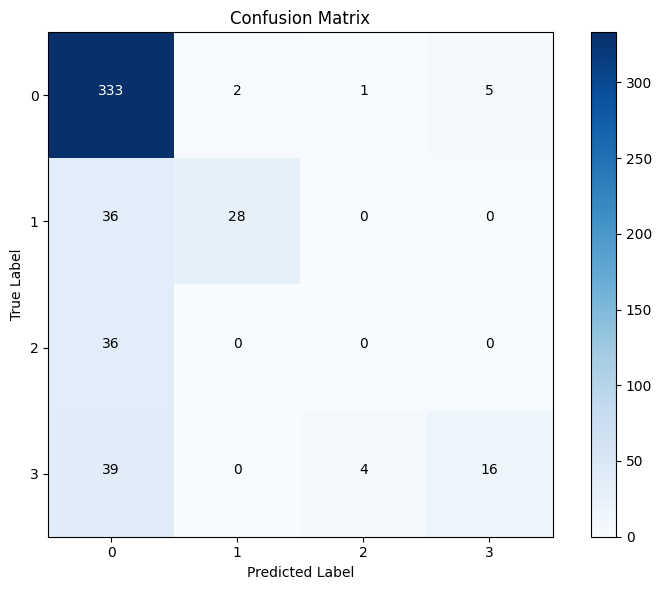

In [14]:
# This is a util script for a better visualisation

import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# Add title and axis labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add color bar
plt.colorbar()

# Add class labels to axis ticks
classes = np.unique(np.concatenate((true_labels, pred_labels)))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Display the values in the cells
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Show plot
plt.tight_layout()
plt.show()

# 📦 Save model

After evaluating your model, don't forget to save its state along with the optimizer's state and the label names for future use.

In [15]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "classes": CLASSES,
    }, "model.pth")

# ☁️ Run in Studio (SaaS)

<a href="https://datachain.ai/">
    <img src="static/images/studio.png" alt="DataChain Studio SaaS" style="width: 600px;"/>
</a>

To run these examples in Studio, follow the guide

1. Open Studio / YOUR_TEAM / `datasets` workspace
2. Create a new Python Script
3. Copy/paste a script from (split into a few smaller scripts for convenience only)
   - `scripts/3-split-train-test.py`
   - `scripts/3-train-model.py`
6. Specify Settings: environment requirements and importing modules
7. Click the Run button


# 🎉 Summary 

**🌟 Congratulations! You've Successfully Completed the Training & Evaluation with DataChain Tutorial! 🌟**

In this tutorial, you've gained a wealth of knowledge and skills that will elevate your computer vision projects to new heights. Let's recap the key topics covered:

1. 🧩 **Splitting Datasets:** Dividing datasets into train, test, and validation subsets using UDF.
2. 🎯 **Defining a Target Variable:** UDFs can be used to assign target labels to your images.
3. 🔄 **Streamlined Data Loading to PyTorch:** DataChain seamlessly integrates with PyTorch for efficient data loaders.
4. 🧠 **Training Your Model:** With a PyTorch Dataloader for train data.
5. 📊 **Evaluating Your Model Like a Pro:**  With a PyTorch Dataloader for test data.


Once again, congratulations on your incredible achievement! 

## What's Next?

Keep exploring, experimenting, and pushing the boundaries of what's possible in computer vision.  Check out the next parts of our tutorial series:
- 🔮 Running Inference and Saving Predictions
- 📊 Analyzing Predictions

By mastering these techniques, you'll be well on your way to building powerful and efficient computer vision pipelines with DataChain.

## Get Involved

We'd love to have you join our growing community of DataChain users and contributors! Here's how you can get involved:
- ⭐ Give us a star on [GitHub](https://github.com/iterative/datachain) to show your support
- 🌐 Visit the [datachain.ai website](https://datachain.ai/) to learn more about our products and services
- 📞 Contact us to discuss how DataChain can help streamline your company's ML workflows
- 🙌 Follow us on social media for the latest updates and insights

Thanks for choosing DataChain, and happy coding! 😄